In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import pandas as pd
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

fashion = "/content/drive/MyDrive/Github/CSCI-5525-final-project/AMAZON_FASHION_5.json"
crafts = "/content/drive/MyDrive/Github/CSCI-5525-final-project/Arts_Crafts_and_Sewing_5.json"
music = "/content/drive/MyDrive/Github/CSCI-5525-final-project/Digital_Music_5.json"
appliances = "/content/drive/MyDrive/Github/CSCI-5525-final-project/Appliances_5.json"

df = pd.read_json(path_or_buf=fashion, lines=True)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
#df['asin'].value_counts()

In [4]:
#list(df[df['asin'] == 'B009MA34NY']['reviewText'])

In [6]:
import json

def import_data(filename):
  with open(filename) as f:
      reviews_json = f.readlines()

  reviews = []
  for review_json in reviews_json:
      review = json.loads(review_json)
      if "overall" in review and "reviewText" in review and 'summary' in review:
          reviews.append(
              {
                  "rating": review["overall"],
                  "title": review["summary"],
                  "text": review["reviewText"],
              }
          )
  return reviews

fashion_reviews = import_data(fashion)
craft_reviews = import_data(crafts)
music_reviews = import_data(music)
appliance_reviews = import_data(appliances)

#df = pd.DataFrame.from_dict(reviews)

In [9]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# NMF and LDA
Adapted from [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html), minimal original work.

The topics are extracting nothing of note.

Further steps:

- find a product with enough reviews to be worth analyzing alone (might have to request the full dataset)
- mess around with heuristics for vectorizing terms (reducing `max_df` probably but didn't manage to get different results)
- eliminate boring reviews?

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
#import sklearn.decomposition
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

product_id = 'B009MA34NY'
if product_id:
    data_samples = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
else:
    data_samples = list(map(lambda x: x['text'], reviews))[:n_samples]

for s in data_samples:

    if not isinstance(s,str):
        print(s)

In [16]:
#preprocessing
#REALLY SLOW; optimize?
def lowercasing(data_samples):
  for idx, sample in enumerate(data_samples):
    data_samples[idx] = sample.lower()
  return data_samples

def punctuation_removal(data_samples):
#non-exhaustive; not sure if we want to treat punctuation as significant
#doesn't remove punctuation from inside words
  for i, sample in enumerate(data_samples):
    _sample = sample.split()
    for j, word in enumerate(_sample):
      _sample[j] = word.strip(" .!?@#&():;,'\/\\")
    sample = " ".join(_sample)
    data_samples[i] = sample
  return data_samples

#credit to Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(data_samples):
  wnl = WordNetLemmatizer()
  for i, sample in enumerate(data_samples):
      _sample = sample.split()
      for j, word in enumerate(_sample):
        tag = get_wordnet_pos(word)
        _sample[j] = wnl.lemmatize(word,tag)
      data_samples[i] = " ".join(_sample)
  return data_samples

def preprocess(data_samples):
  data_samples = lowercasing(data_samples)
  data_samples = punctuation_removal(data_samples)
  data_samples = lemmatize(data_samples)
  return data_samples

data_samples = preprocess(data_samples)

In [101]:
#customize stopwords

def create_samples(reviews): 
  data = list(map(lambda x: x['text'], reviews))[:n_samples]
  return data

fashion_data = preprocess(create_samples(fashion_reviews))
craft_data = preprocess(create_samples(craft_reviews))
music_data = preprocess(create_samples(music_reviews))
#appliance data is particularly slow
appliance_data = preprocess(create_samples(appliance_reviews))

In [102]:
fashion_data = ' '.join(fashion_data)
craft_data = ' '.join(craft_data)
music_data = ' '.join(music_data)
appliance_data = ' '.join(appliance_data)

cross_set_data = []
cross_set_data.append(fashion_data)
cross_set_data.append(craft_data)
cross_set_data.append(music_data)
cross_set_data.append(appliance_data)

In [103]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=500, min_df=2, max_features=n_features, stop_words='english'
)
tfidf = tfidf_vectorizer.fit_transform(cross_set_data)

cross_set_stop_words = tfidf_vectorizer.get_stop_words()

In [104]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.03, min_df=2, max_features=n_features, stop_words=cross_set_stop_words
)
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print(tfidf.shape)

Extracting tf-idf features for NMF...
(375, 393)


In [53]:
len(data_samples)

375

In [105]:
print(len(tfidf_vectorizer.stop_words_))
tfidf_vectorizer.stop_words_

682


{'000',
 '100',
 '12',
 '15',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '30',
 '3rd',
 '3s',
 '3x',
 '40',
 '50',
 'abd',
 'abit',
 'absolutly',
 'absorption',
 'accommodate',
 'accurately',
 'ache',
 'ached',
 'aches',
 'achilles',
 'aching',
 'activity',
 'adding',
 'adjust',
 'adjustment',
 'advice',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'anymore',
 'apart',
 'appear',
 'appears',
 'arch',
 'areas',
 'arose',
 'artculo',
 'asics',
 'attention',
 'az',
 'bag',
 'bailing',
 'balance',
 'balances',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'barely',
 'base',
 'based',
 'beach',
 'beat',
 'bed',
 'believe',
 'bend',
 'big',
 'blood',
 'bluffs',
 'bootcamps',
 'bothering',
 'bothers',
 'bought',
 'boxier',
 'breath',
 'breathe',
 'breathes',
 'broader',
 'btw',
 'build',
 'bulk',
 'bunion',
 'business',
 'buy',
 'cable',
 'calves',
 'cam',
 'card',
 'care',
 'careful',
 'carpet',
 'carpeted',
 'certain',
 'certainly',
 'change',
 'cheap',
 'check',
 'chic',

In [106]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)


Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


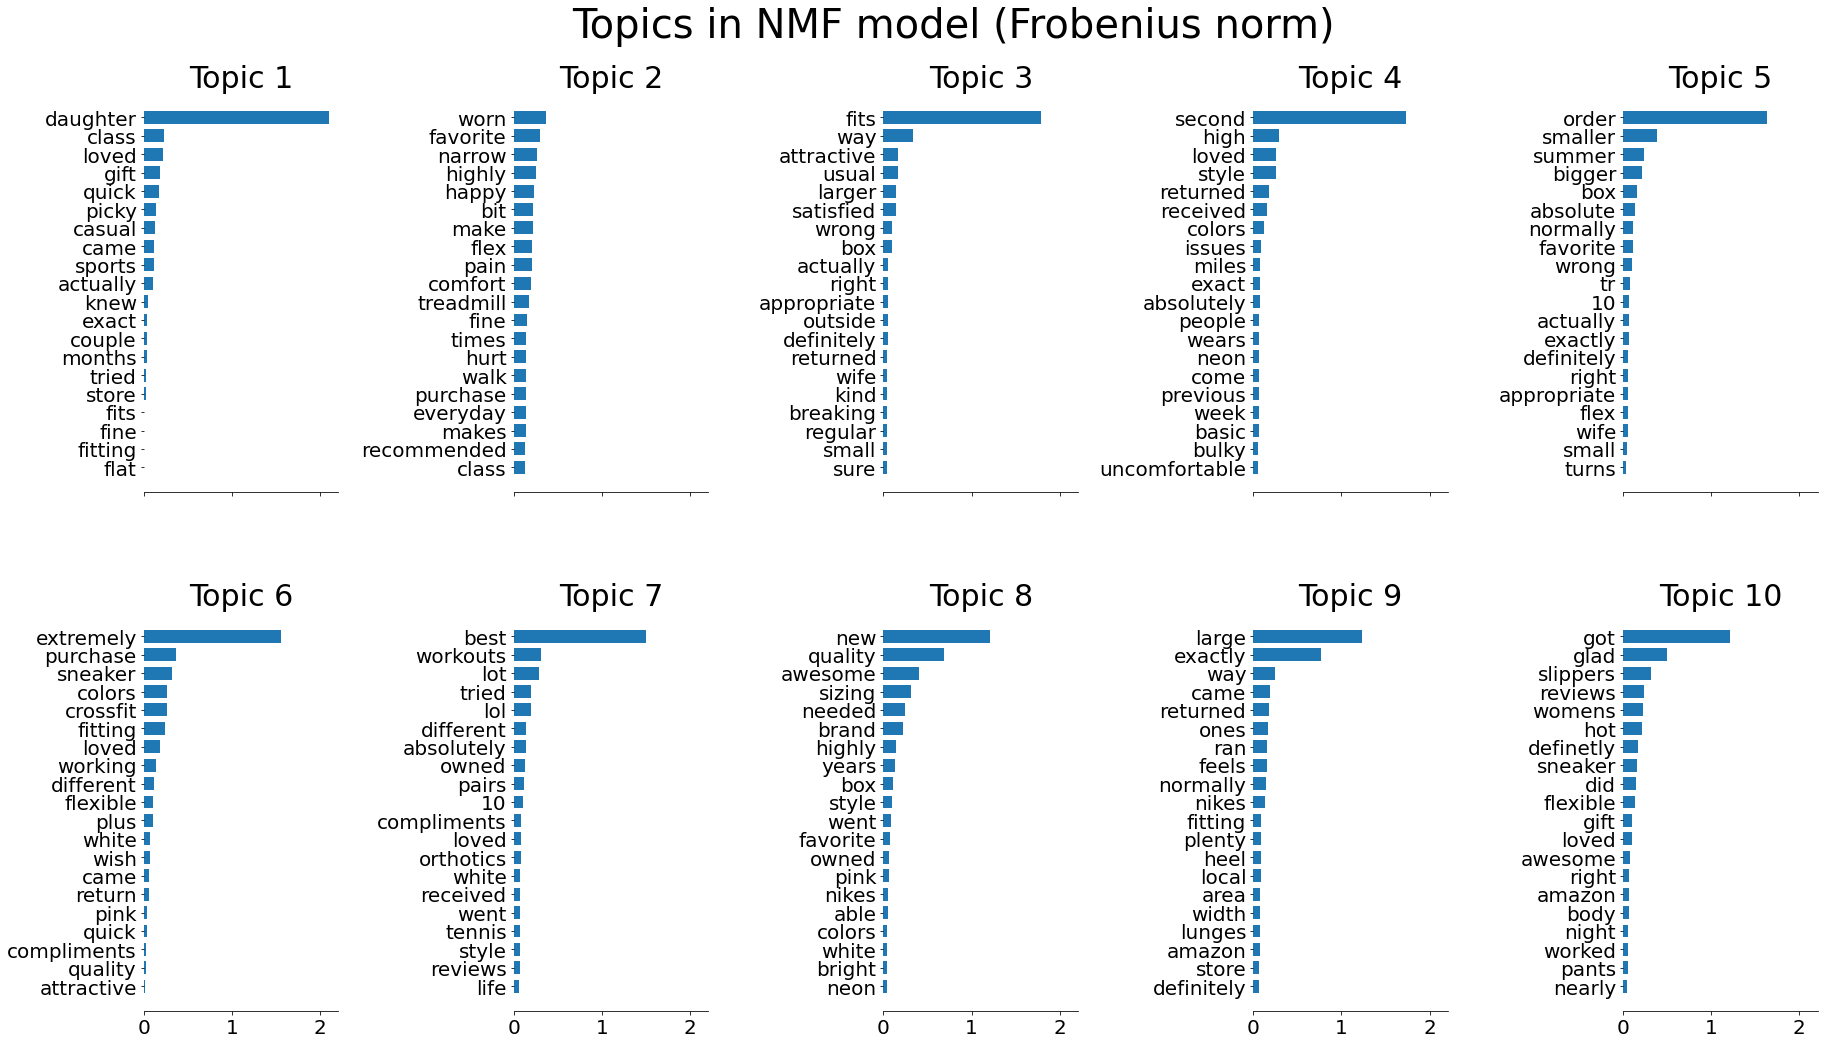

In [85]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, 
    tfidf_feature_names, 
    n_top_words, 
    "Topics in NMF model (Frobenius norm)"
)

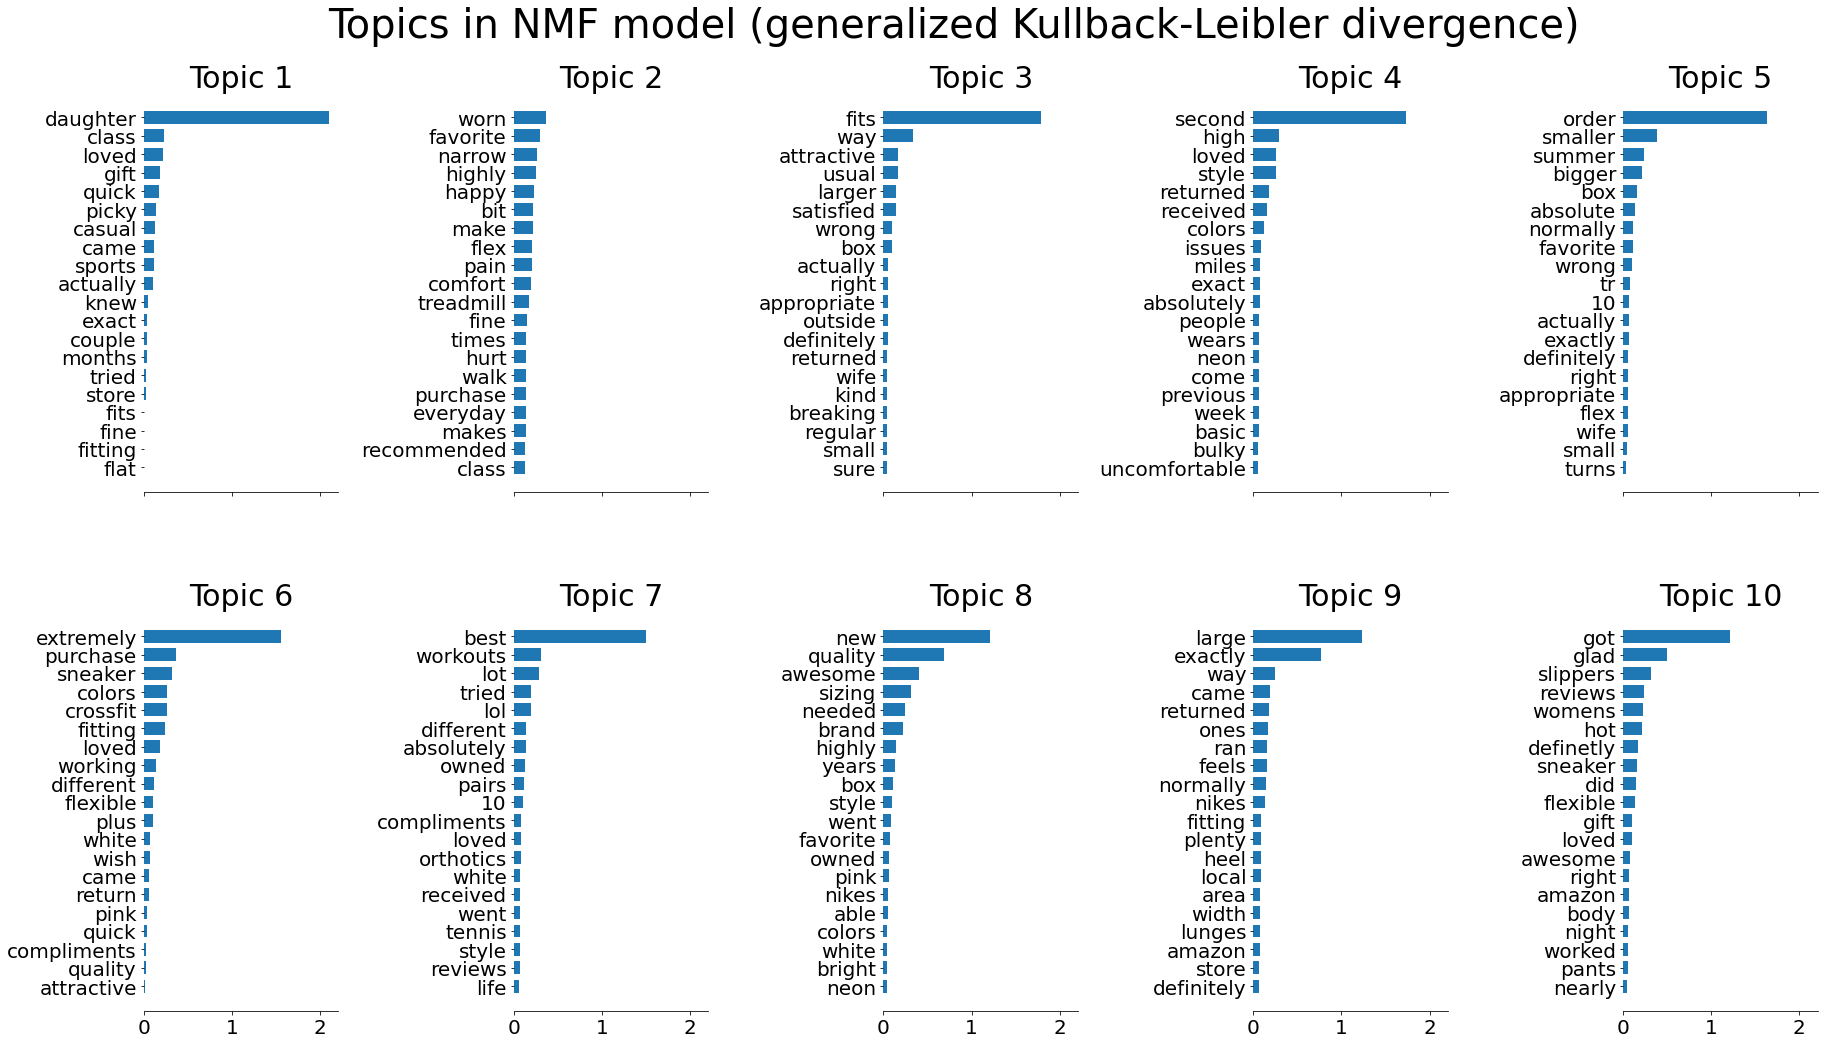

In [86]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

In [ ]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


/Users/shy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:2308: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


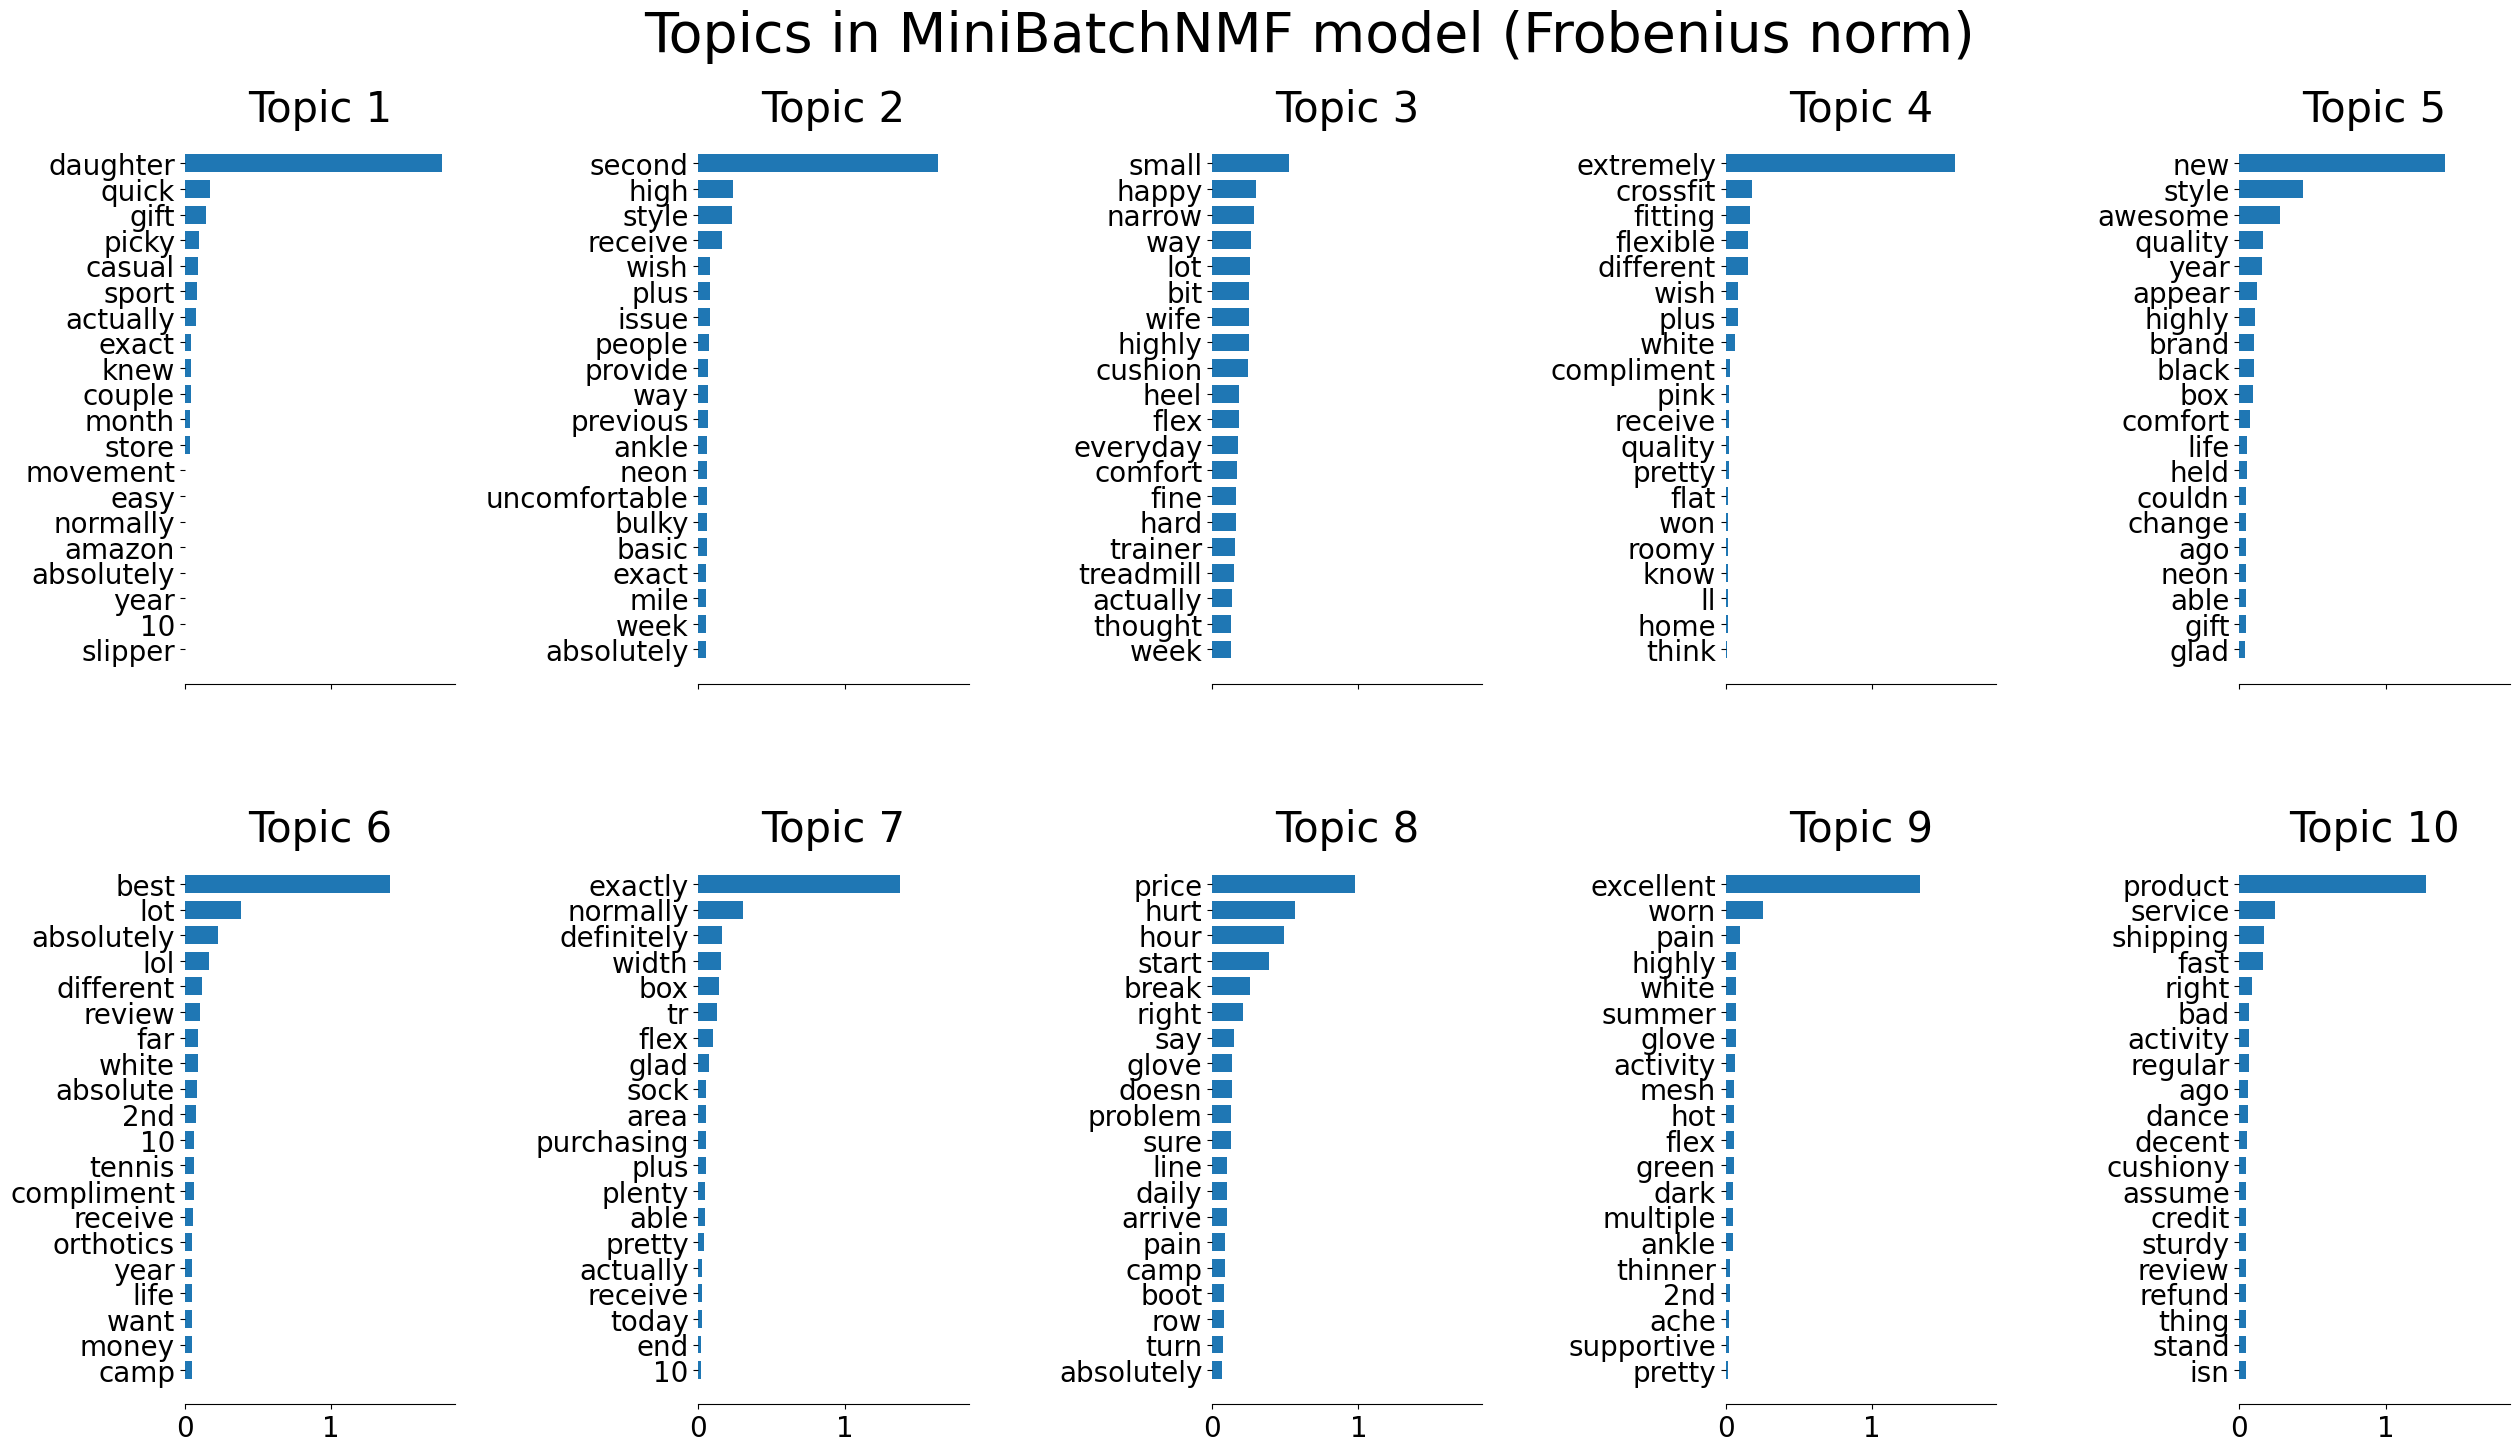

In [ ]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

In [ ]:
# Fit the MiniBatchNMF model
print(
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


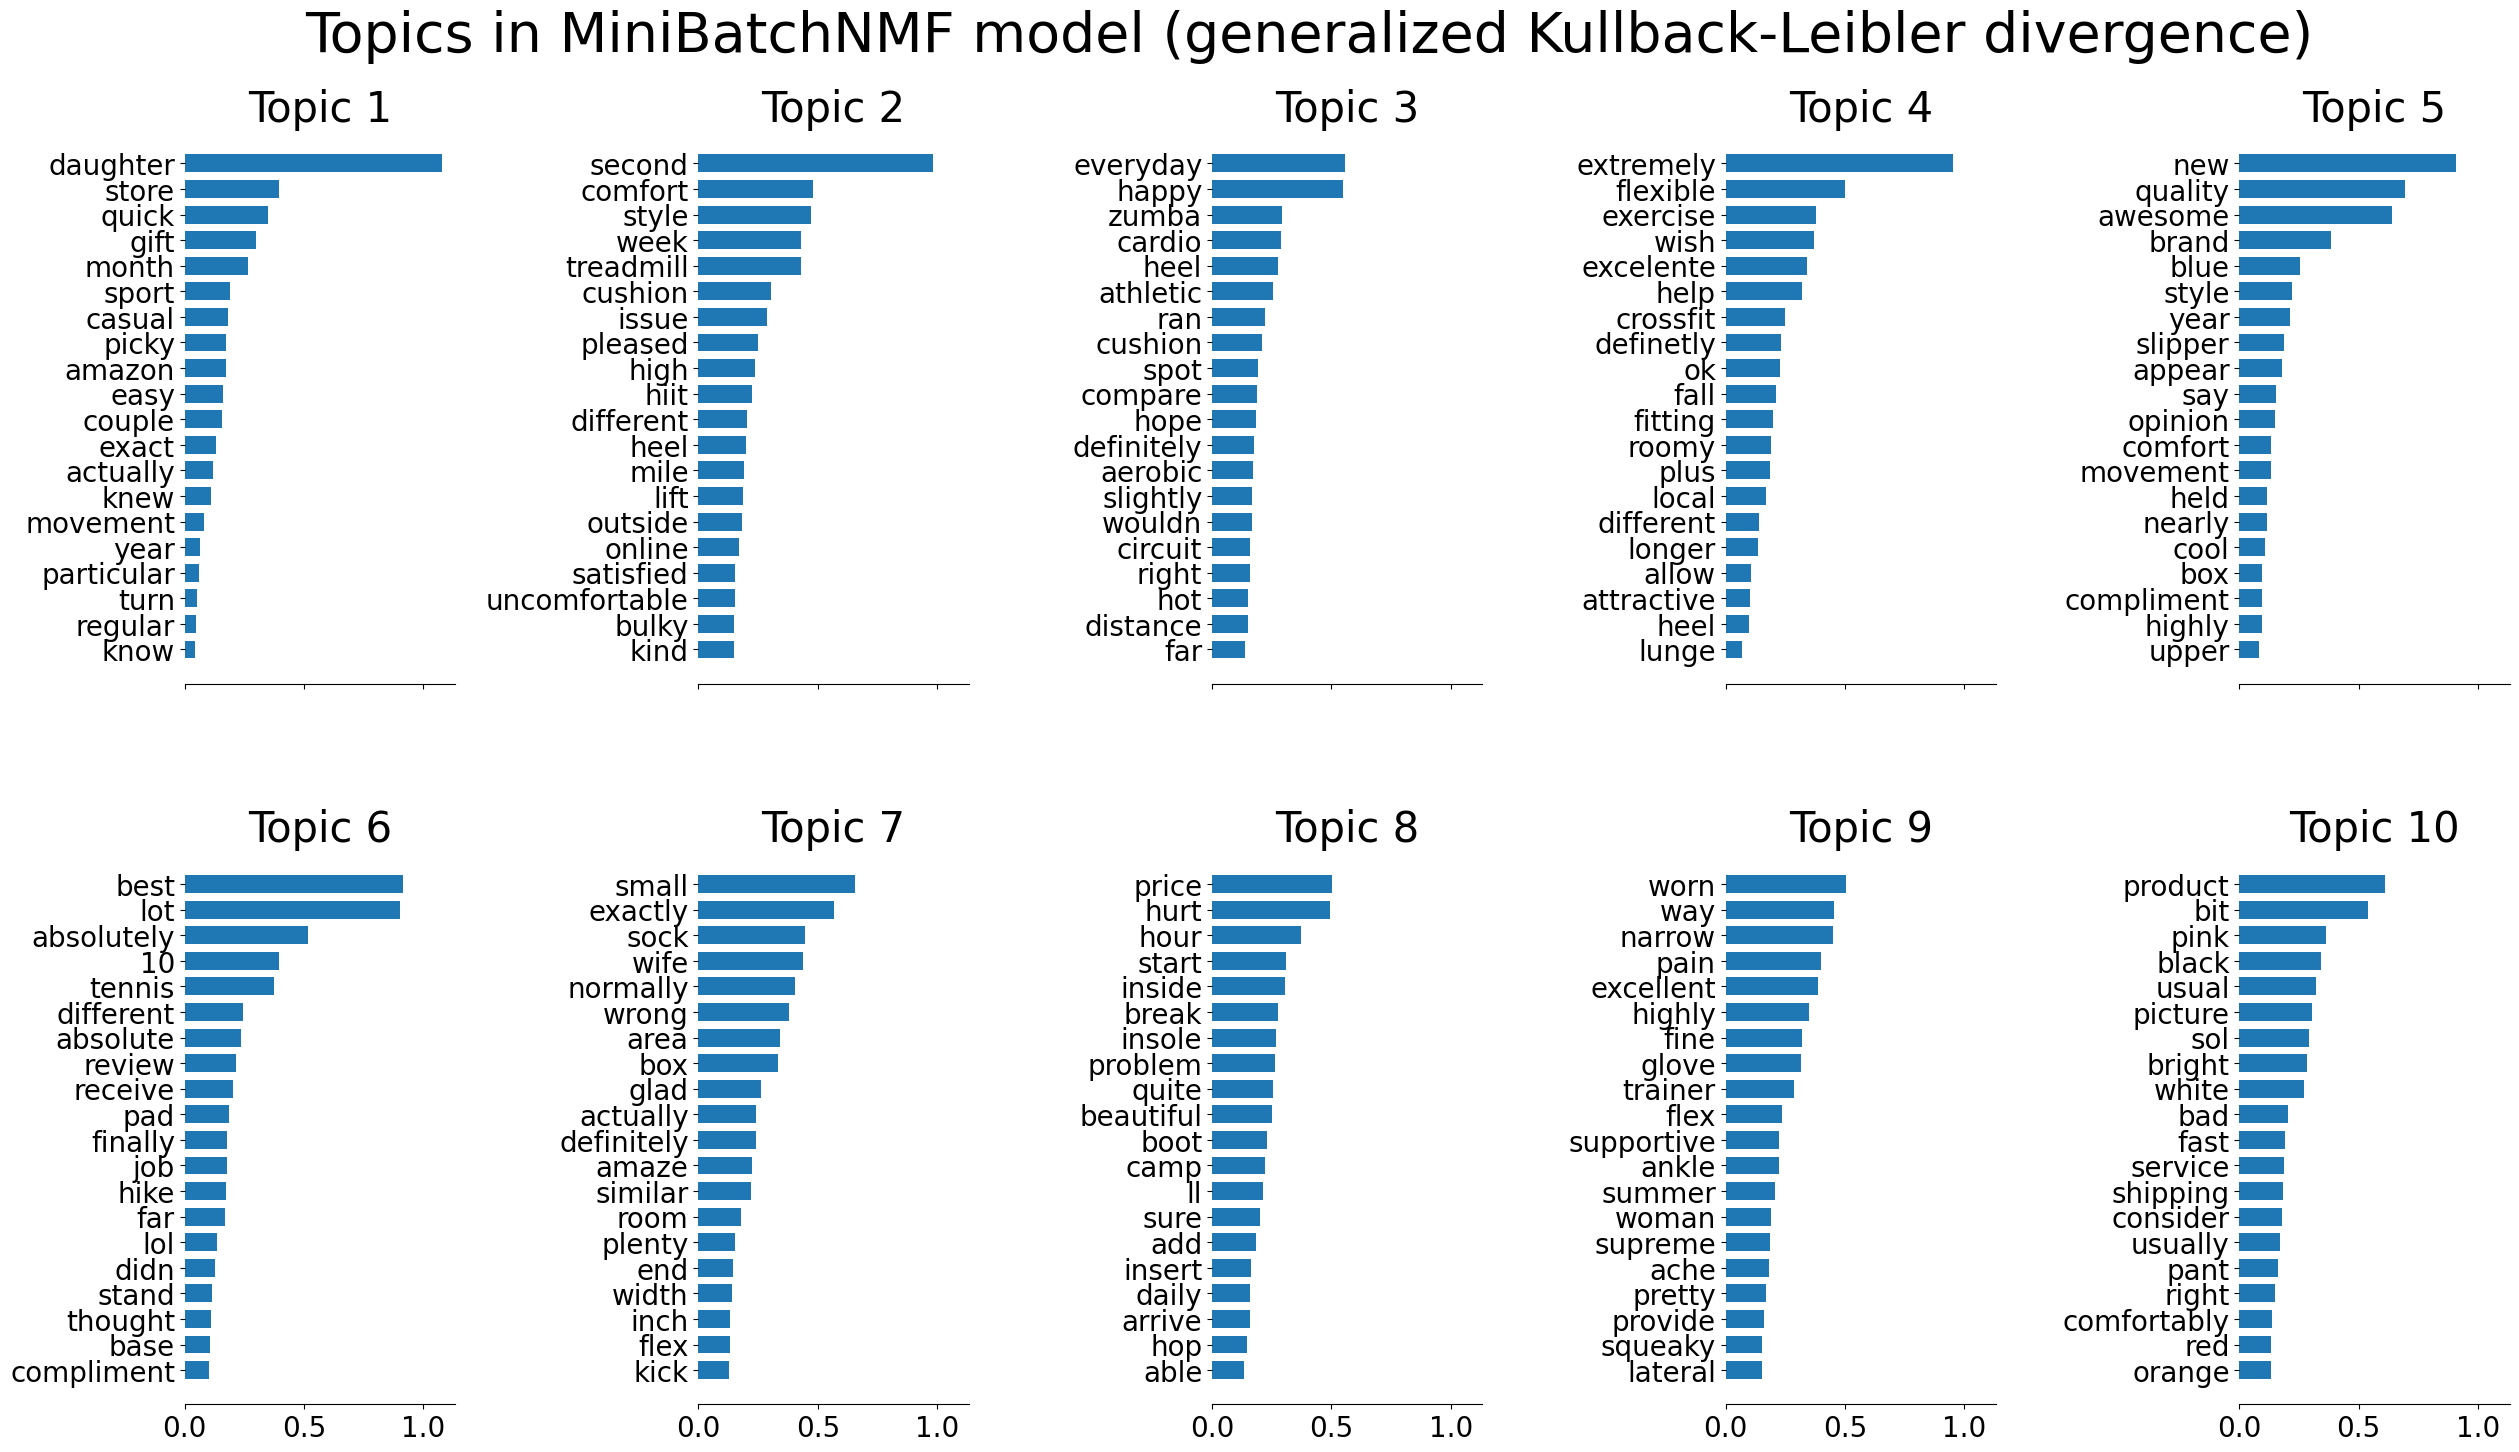

In [ ]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

In [107]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.01, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_samples)
tf_vectorizer.stop_words_

Extracting tf features for LDA...


{'000',
 '10',
 '100',
 '12',
 '15',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '30',
 '3rd',
 '3s',
 '3x',
 '40',
 '50',
 'abd',
 'abit',
 'able',
 'absolutely',
 'absolutly',
 'absorption',
 'accommodate',
 'accurately',
 'ache',
 'ached',
 'aches',
 'achilles',
 'aching',
 'activity',
 'actually',
 'adding',
 'adjust',
 'adjustment',
 'advice',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'amazing',
 'amazon',
 'ankle',
 'anymore',
 'apart',
 'appear',
 'appears',
 'arch',
 'arches',
 'area',
 'areas',
 'arose',
 'arrived',
 'artculo',
 'asics',
 'athletic',
 'attention',
 'away',
 'awesome',
 'az',
 'bag',
 'bailing',
 'balance',
 'balances',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'barely',
 'base',
 'based',
 'beach',
 'beat',
 'bed',
 'believe',
 'bend',
 'best',
 'better',
 'big',
 'bigger',
 'bit',
 'black',
 'blood',
 'bluffs',
 'boot',
 'bootcamps',
 'bothering',
 'bothers',
 'bought',
 'box',
 'boxier',
 'brand',
 'breaking',
 'breath',
 'breathe',


Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


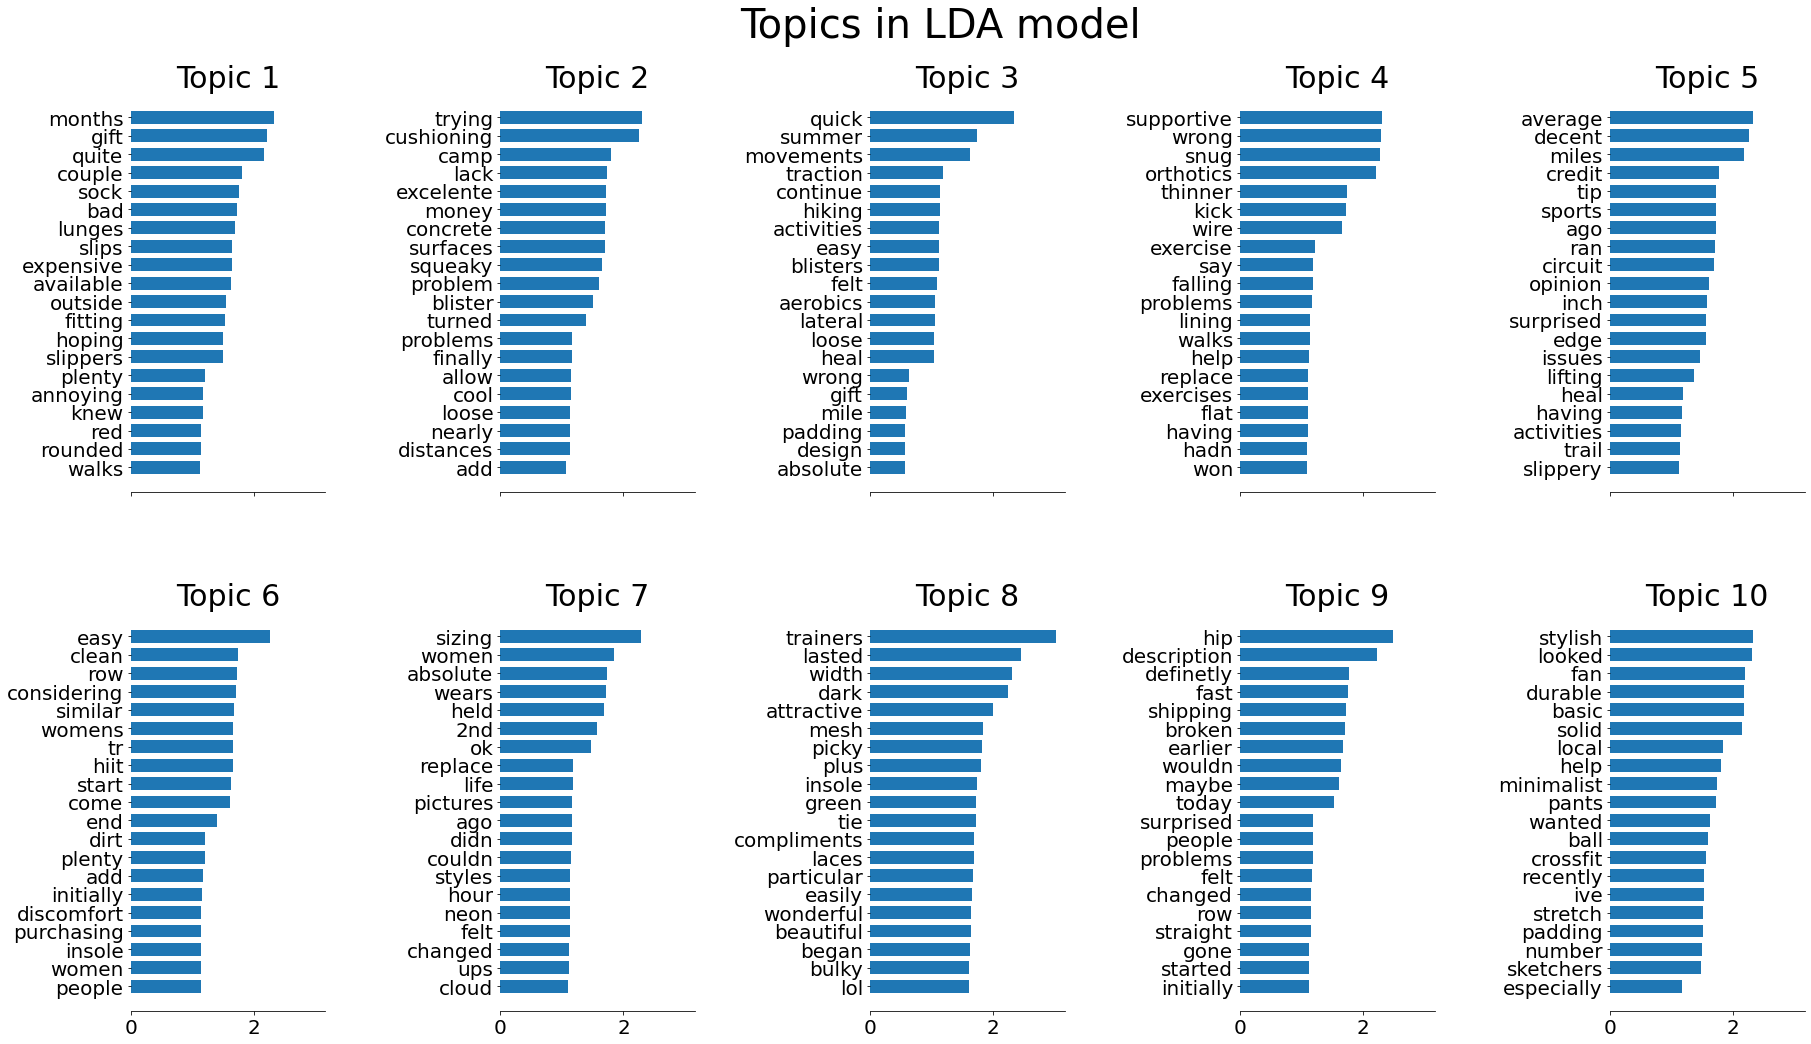

In [108]:
print(
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [ ]:
for i, sample in enumerate(data_samples):
    if len(sample) > 300 and len(sample) < 700:
        print(i,":", sample)

4 : try them on in a store before buying online so i knew they'd fit good overall i be look for a durable cross training shoe that would hold up to my rigorous training and these have be great so far they be really light and comfortable most importantly for me they have grip on the bottom so my foot don't slide out from under me while do plank push-ups etc highly satisfied with this purchase
60 : glad i read the review and order a half size too big these be light weight i work out in them last night and have a great work out they be very comfortable i would recommend these to anyone i be a beach body coach and these be now my new favorite shoe to work out in i feel like i be walk in slipper when i wear these shoe they be so comfortable i love them so much i never buy myself anything nice and for christmas get an amazon gift card and use it to buy myself these sneaker and they be so awesome i really do love them and have be tell all my friend about them get these shoe
62 : i love these 

In [ ]:
lda.transform(tf_vectorizer.transform([data_samples[13]]))

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])

In [ ]:
data_samples[13]

'love these shoe they be so comfortable'

In [ ]:
from nltk import sent_tokenize


raw_reviews = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
raw_sentences = sent_tokenize(raw_reviews[4])

processed_sentences = raw_sentences[:]
processed_sentences = lowercasing(processed_sentences)
processed_sentences = punctuation_removal(processed_sentences)
processed_sentences = lemmatize(processed_sentences)

print(raw_sentences)
processed_sentences

["Tried them on in a store before buying online so I knew they'd fit good.", 'Overall I was looking for a durable cross training shoe that would hold up to my rigorous training and these have been great so far.', 'They are really light and comfortable.', "Most importantly for me they have grips on the bottoms so my feet don't slide out from under me while doing planks, push-ups, etc.", 'Highly satisfied with this purchase.']


["try them on in a store before buying online so i knew they'd fit good",
 'overall i be look for a durable cross training shoe that would hold up to my rigorous training and these have be great so far',
 'they be really light and comfortable',
 "most importantly for me they have grip on the bottom so my foot don't slide out from under me while do plank push-ups etc",
 'highly satisfied with this purchase']

In [ ]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# TODO: for now compound (a composite score) will suffice. Neutrality (neu) might suggest highly informational content.
for raw, processed in zip(raw_sentences, processed_sentences):
    vs = analyzer.polarity_scores(raw)
    probs = lda.transform(tf_vectorizer.transform([processed]))[0]
    topic = probs.argmax()
    if probs[topic] < 0.2:
        print("{} \n\t{:.2f}, No Topic\n".format(raw, vs['compound']))
    else:
        print("{} \n\t{:.2f}, Topic {}: {}\n".format(raw, vs['compound'], topic+1, ", ".join(topic_words[topic])))

Tried them on in a store before buying online so I knew they'd fit good. 
	0.66, Topic 7: easy, gift, life, exact, opinion, movement, dark, photo, couple, job

Overall I was looking for a durable cross training shoe that would hold up to my rigorous training and these have been great so far. 
	0.46, Topic 4: row, add, casual, trail, insert, initially, resistance, insole, blue, floor

They are really light and comfortable. 
	0.55, No Topic

Most importantly for me they have grips on the bottoms so my feet don't slide out from under me while doing planks, push-ups, etc. 
	0.38, Topic 4: row, add, casual, trail, insert, initially, resistance, insole, blue, floor

Highly satisfied with this purchase. 
	0.48, No Topic



In [ ]:
lda.transform(tf_vectorizer.transform(["easy gift life"])).argmax()
topic_words[6]

['easy',
 'gift',
 'life',
 'exact',
 'opinion',
 'movement',
 'dark',
 'photo',
 'couple',
 'job']